In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [7]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

In [8]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [9]:
# train = train.drop(train[train['SalePrice'] > 350000].index) ## worse


In [10]:
df = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [11]:
# before tuning
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,Missing value,N unique value,dtype
MSSubClass,0,16,int64
MSZoning,4,5,object
LotFrontage,486,128,float64
LotArea,0,1951,int64
Street,0,2,object
Alley,2721,2,object
LotShape,0,4,object
LandContour,0,4,object
Utilities,2,2,object
LotConfig,0,5,object


<AxesSubplot:xlabel='MasVnrArea'>

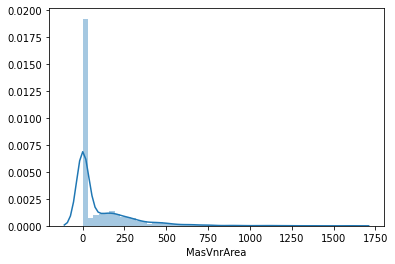

In [12]:
sns.distplot(df['MasVnrArea'])

In [13]:
df['MasVnrArea'].head(1000)

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
5         0.0
6       186.0
7       240.0
8         0.0
9         0.0
10        0.0
11      286.0
12        0.0
13      306.0
14      212.0
15        0.0
16      180.0
17        0.0
18        0.0
19        0.0
20      380.0
21        0.0
22      281.0
23        0.0
24        0.0
25      640.0
26        0.0
27      200.0
28        0.0
29        0.0
30        0.0
31        0.0
32        0.0
33        0.0
34      246.0
35      132.0
36        0.0
37      650.0
38        0.0
39        0.0
40      101.0
41        0.0
42        0.0
43        0.0
44        0.0
45      412.0
46        0.0
47        0.0
48        0.0
49        0.0
50        0.0
51        0.0
52        0.0
53        0.0
54        0.0
55      272.0
56      456.0
57        0.0
58     1031.0
59        0.0
60        0.0
61        0.0
62      178.0
63        0.0
64      573.0
65      344.0
66      287.0
67      167.0
68        0.0
69        0.0
70     1115.0
71    

In [14]:
scaler = MinMaxScaler((-1,1))

df['BsmtFinSF2_sc'] = scaler.fit_transform(df[['BsmtFinSF2']])
df['BsmtFinSF2_sc'].fillna(0,inplace=True)
df['LowQualFinSF_sc'] = scaler.fit_transform(df[['LowQualFinSF']])
df['WoodDeckSF_sc'] = scaler.fit_transform(df[['WoodDeckSF']])
df['OpenPorchSF_sc'] = scaler.fit_transform(df[['OpenPorchSF']])
df['EnclosedPorch_sc'] = scaler.fit_transform(df[['EnclosedPorch']])
df['3SsnPorch_sc'] = scaler.fit_transform(df[['3SsnPorch']])
df['ScreenPorch_sc'] = scaler.fit_transform(df[['ScreenPorch']])
df['MiscVal_sc'] = scaler.fit_transform(df[['MiscVal']])

df['MSZoning'].fillna('N')
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace = True)
df['Alley'].fillna('N')
df['Exterior1st'].fillna('N')
df['Exterior2nd'].fillna('N')
df['Utilities'].fillna('N')
df['MasVnrType'].fillna('N')
df['BsmtFullBath'].fillna(0)
df['BsmtHalfBath'].fillna(0)
df['FullBath'].fillna(0)
df['HalfBath'].fillna(0)
df['KitchenQual'].fillna('N')
df['Functional'].fillna('N')
df['FireplaceQu'].fillna('N')
df['GarageType'].fillna('N')
df['GarageYrBlt'].fillna(0,inplace=True)
df['GarageFinish'].fillna('N')
df['GarageCars'].fillna(0)
df['GarageArea'].fillna(0,inplace=True)
df['GarageQual'].fillna('N')
df['GarageCond'].fillna('N')
df['BsmtFinSF2'].fillna(0,inplace=True)
df['MasVnrArea'].fillna(0,inplace=True)
df['BsmtFinSF1'].fillna(0,inplace=True)
df['SaleType'].fillna('N')
df['BsmtUnfSF'].fillna(0,inplace=True)
df['TotalBsmtSF'].fillna(0,inplace=True)
df['PoolQC'].fillna('N')
df['Fence'].fillna('N')
df['MiscFeature'].fillna('N')
df['BsmtQual'].fillna('N')
df['BsmtCond'].fillna('N')
df['BsmtExposure'].fillna('N')
df['BsmtFinType1'].fillna('N')
df['BsmtFinType2'].fillna('N')
df['Electrical'].fillna('N')
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
df['Area'] = df['LotArea']*df['LotFrontage']
df['Area_log'] = np.log1p(df['Area'])

def Gar_category(cat):
    if cat <= 250:
        return 1
    elif cat <= 500 and cat > 250:
        return 2
    elif cat <= 1000 and cat > 500:
        return 3
    return 4
df['GarageArea_cat'] = df['GarageArea'].apply(Gar_category)

def Low_category(cat):
    if cat <= 1000:
        return 1
    elif cat <= 2000 and cat > 1000:
        return 2
    elif cat <= 3000 and cat > 2000:
        return 3
    return 4
df['GrLivArea_cat'] = df['GrLivArea'].apply(Low_category)

def fl1_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['1stFlrSF_cat'] = df['1stFlrSF'].apply(fl1_category)
df['2ndFlrSF_cat'] = df['2ndFlrSF'].apply(fl1_category)

def bsmtt_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['TotalBsmtSF_cat'] = df['TotalBsmtSF'].apply(bsmtt_category)

def bsmt_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['BsmtUnfSF_cat'] = df['BsmtUnfSF'].apply(bsmt_category)

def lot_category(cat):
    if cat <= 50:
        return 1
    elif cat <= 100 and cat > 50:
        return 2
    elif cat <= 150 and cat > 100:
        return 3
    return 4
df['LotFrontage_cat'] = df['LotFrontage'].apply(lot_category)

def lot_category1(cat):
    if cat <= 5000:
        return 1
    elif cat <= 10000 and cat > 5000:
        return 2
    elif cat <= 15000 and cat > 10000:
        return 3
    elif cat <= 20000 and cat > 15000:
        return 4
    elif cat <= 25000 and cat > 20000:
        return 5
    return 6
df['LotArea_cat'] = df['LotArea'].apply(lot_category1)

def year_category(yb):
    if yb <= 1910:
        return 1
    elif yb <= 1950 and yb > 1910:
        return 2
    elif yb >= 1950 and yb < 1980:
        return 3
    elif yb >= 1980 and yb < 2000:
        return 4
    return 5



df['YearBuilt_cat'] = df['YearBuilt'].apply(year_category) 
df['YearRemodAdd_cat'] = df['YearRemodAdd'].apply(year_category)
df['GarageYrBlt_cat'] = df['GarageYrBlt'].apply(year_category)

def vnr_category(cat):
    if cat <= 250:
        return 1
    elif cat <= 500 and cat > 250:
        return 2
    elif cat <= 750 and cat > 500:
        return 3
    return 4

df['MasVnrArea_cat'] = df['MasVnrArea'].apply(vnr_category)

def allsf_category(yb):
    if yb <= 1000:
        return 1
    elif yb <= 2000 and yb > 1000:
        return 2
    elif yb >= 3000 and yb < 2000:
        return 3
    elif yb >= 4000 and yb < 3000:
        return 4
    elif yb >= 5000 and yb < 4000:
        return 5
    elif yb >= 6000 and yb < 5000:
        return 6
    return 7

df['AllSF_cat'] = df['AllSF'].apply(allsf_category)


dummy_col=['YearRemodAdd', 'YearBuilt', 'AllSF_cat', 'MiscVal','OverallCond', 'OverallQual', 'BsmtFinType2', 'SaleCondition','SaleType', 'YrSold', 'MoSold', 'MiscFeature', 'Fence', 'PoolQC', 'PoolArea', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageArea_cat', 'GarageCars', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Fireplaces','Functional', 'TotRmsAbvGrd', 'KitchenQual', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath','GrLivArea_cat','MSSubClass', 'MSZoning', 'LotFrontage_cat', 'LotArea_cat', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
          'BldgType', 'HouseStyle', 'YearBuilt_cat', 'YearRemodAdd_cat', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'Exterior1st', 'MasVnrType', 'MasVnrArea_cat', 'ExterQual', 'ExterCond', 'Foundation', 
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF_cat', 'TotalBsmtSF_cat', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF_cat', '2ndFlrSF_cat']
df = pd.get_dummies(df, columns=dummy_col, drop_first=False)

df['LotFrontage_log'] = np.log1p(df['LotFrontage'])
df['LotArea_log'] = np.log1p(df['LotArea'])
df['BsmtUnfSF_log'] = np.log1p(df['BsmtUnfSF'])

df['Is_MasVnr'] = [1 if i != 0 else 0 for i in df['MasVnrArea']]
df['Is_BsmtFinSF1'] = [1 if i != 0 else 0 for i in df['BsmtFinSF1']]
df['Is_BsmtFinSF2'] = [1 if i != 0 else 0 for i in df['BsmtFinSF2']]
df['Is_BsmtUnfSF'] = [1 if i != 0 else 0 for i in df['BsmtUnfSF']]
df['Is_TotalBsmtSF'] = [1 if i != 0 else 0 for i in df['TotalBsmtSF']]
df['Is_2ndFlrSF'] = [1 if i != 0 else 0 for i in df['2ndFlrSF']]
df['Is_LowQualFinSF'] = [1 if i != 0 else 0 for i in df['LowQualFinSF']]
df['Is_GarageArea'] = [1 if i != 0 else 0 for i in df['GarageArea']]
df['Is_WoodDeckSF'] = [1 if i != 0 else 0 for i in df['WoodDeckSF']]
df['Is_OpenPorchSF'] = [1 if i != 0 else 0 for i in df['OpenPorchSF']]
df['Is_EnclosedPorch'] = [1 if i != 0 else 0 for i in df['EnclosedPorch']]
df['Is_3SsnPorch'] = [1 if i != 0 else 0 for i in df['3SsnPorch']]
df['Is_ScreenPorch'] = [1 if i != 0 else 0 for i in df['ScreenPorch']]




In [15]:
# after tuning
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,Missing value,N unique value,dtype
LotFrontage,0,128,float64
LotArea,0,1951,int64
MasVnrArea,0,444,float64
BsmtFinSF1,0,991,float64
BsmtFinSF2,0,272,float64
BsmtUnfSF,0,1135,float64
TotalBsmtSF,0,1058,float64
1stFlrSF,0,1083,int64
2ndFlrSF,0,635,int64
LowQualFinSF,0,36,int64


In [16]:
df.shape

(2919, 687)

In [17]:
def descrictive_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in df.columns if df[c].nunique()>=10]
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 10 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df

df = descrictive_stat_feat(df)

In [18]:
df.shape

(2919, 815)

In [19]:
tot_cat_col = list(df.select_dtypes(include=['category']).columns)
num_col = [c for c in df.columns if c not in tot_cat_col]

In [20]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
                
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
outlier(df,num_col)

LotFrontage 33.0 105.0 21.0 132.64000000000033
LotArea 1340.0 17708.0 1680.0 33038.64000000007
MasVnrArea -245.25 408.75 0.0 770.4600000000005
BsmtFinSF1 -1099.5 1832.5 0.0 1635.2800000000007
BsmtFinSF2 0.0 0.0 0.0 874.6400000000003
BsmtUnfSF -657.5 1682.5 0.0 1776.4600000000005
TotalBsmtSF 29.5 2065.5 0.0 2198.2000000000016
1stFlrSF 108.75 2154.75 520.0 2288.020000000002
2ndFlrSF -1056.0 1760.0 0.0 1400.2000000000016
LowQualFinSF 0.0 0.0 0.0 153.84000000000196
GrLivArea 199.75 2669.75 675.42 2935.7200000000075
GarageYrBlt 1891.0 2067.0 0.0 2009.0
GarageArea -64.0 960.0 0.0 1019.4600000000005
WoodDeckSF -252.0 420.0 0.0 500.82000000000016
OpenPorchSF -105.0 175.0 0.0 284.4600000000005
EnclosedPorch 0.0 0.0 0.0 264.0
3SsnPorch 0.0 0.0 0.0 144.0
ScreenPorch 0.0 0.0 0.0 259.82000000000016
BsmtFinSF2_sc -1.0 -1.0 -1.0 0.14631716906946307
LowQualFinSF_sc -1.0 -1.0 -1.0 -0.7108270676691694
WoodDeckSF_sc -1.353932584269663 -0.41011235955056174 -1.0 -0.29660112359550544
OpenPorchSF_sc -1.28301

OverallCond_9 0.0 0.0 0.0 1.0
OverallQual_1 0.0 0.0 0.0 0.0
OverallQual_2 0.0 0.0 0.0 0.0
OverallQual_3 0.0 0.0 0.0 1.0
OverallQual_4 0.0 0.0 0.0 1.0
OverallQual_5 -1.5 2.5 0.0 1.0
OverallQual_6 -1.5 2.5 0.0 1.0
OverallQual_7 0.0 0.0 0.0 1.0
OverallQual_8 0.0 0.0 0.0 1.0
OverallQual_9 0.0 0.0 0.0 1.0
OverallQual_10 0.0 0.0 0.0 1.0
BsmtFinType2_ALQ 0.0 0.0 0.0 1.0
BsmtFinType2_BLQ 0.0 0.0 0.0 1.0
BsmtFinType2_GLQ 0.0 0.0 0.0 1.0
BsmtFinType2_LwQ 0.0 0.0 0.0 1.0
BsmtFinType2_Rec 0.0 0.0 0.0 1.0
BsmtFinType2_Unf 1.0 1.0 0.0 1.0
SaleCondition_Abnorml 0.0 0.0 0.0 1.0
SaleCondition_AdjLand 0.0 0.0 0.0 0.0
SaleCondition_Alloca 0.0 0.0 0.0 0.0
SaleCondition_Family 0.0 0.0 0.0 1.0
SaleCondition_Normal 1.0 1.0 0.0 1.0
SaleCondition_Partial 0.0 0.0 0.0 1.0
SaleType_COD 0.0 0.0 0.0 1.0
SaleType_CWD 0.0 0.0 0.0 0.0
SaleType_Con 0.0 0.0 0.0 0.0
SaleType_ConLD 0.0 0.0 0.0 0.0
SaleType_ConLI 0.0 0.0 0.0 0.0
SaleType_ConLw 0.0 0.0 0.0 0.0
SaleType_New 0.0 0.0 0.0 1.0
SaleType_Oth 0.0 0.0 0.0 0.0
SaleTy

BldgType_2fmCon 0.0 0.0 0.0 1.0
BldgType_Duplex 0.0 0.0 0.0 1.0
BldgType_Twnhs 0.0 0.0 0.0 1.0
BldgType_TwnhsE 0.0 0.0 0.0 1.0
HouseStyle_1.5Fin 0.0 0.0 0.0 1.0
HouseStyle_1.5Unf 0.0 0.0 0.0 0.0
HouseStyle_1Story -1.5 2.5 0.0 1.0
HouseStyle_2.5Fin 0.0 0.0 0.0 0.0
HouseStyle_2.5Unf 0.0 0.0 0.0 0.0
HouseStyle_2Story -1.5 2.5 0.0 1.0
HouseStyle_SFoyer 0.0 0.0 0.0 1.0
HouseStyle_SLvl 0.0 0.0 0.0 1.0
YearBuilt_cat_1 0.0 0.0 0.0 1.0
YearBuilt_cat_2 0.0 0.0 0.0 1.0
YearBuilt_cat_3 -1.5 2.5 0.0 1.0
YearBuilt_cat_4 0.0 0.0 0.0 1.0
YearBuilt_cat_5 -1.5 2.5 0.0 1.0
YearRemodAdd_cat_2 0.0 0.0 0.0 1.0
YearRemodAdd_cat_3 -1.5 2.5 0.0 1.0
YearRemodAdd_cat_4 0.0 0.0 0.0 1.0
YearRemodAdd_cat_5 -1.5 2.5 0.0 1.0
RoofStyle_Flat 0.0 0.0 0.0 0.0
RoofStyle_Gable 1.0 1.0 0.0 1.0
RoofStyle_Gambrel 0.0 0.0 0.0 0.0
RoofStyle_Hip 0.0 0.0 0.0 1.0
RoofStyle_Mansard 0.0 0.0 0.0 0.0
RoofStyle_Shed 0.0 0.0 0.0 0.0
RoofMatl_ClyTile 0.0 0.0 0.0 0.0
RoofMatl_CompShg 1.0 1.0 0.0 1.0
RoofMatl_Membran 0.0 0.0 0.0 0.0
RoofMa

WoodDeckSF_sc_median_range -1.5 2.5 0.0 1.0
WoodDeckSF_sc_mean_range -1.5 2.5 0.0 1.0
WoodDeckSF_sc_q1 0.0 0.0 0.0 0.0
WoodDeckSF_sc_q3 0.0 0.0 0.0 1.0
OpenPorchSF_sc_median_range -1.5 2.5 0.0 1.0
OpenPorchSF_sc_mean_range -1.5 2.5 0.0 1.0
OpenPorchSF_sc_q1 0.0 0.0 0.0 0.0
OpenPorchSF_sc_q3 0.0 0.0 0.0 1.0
EnclosedPorch_sc_median_range 0.0 0.0 0.0 1.0
EnclosedPorch_sc_mean_range 0.0 0.0 0.0 1.0
EnclosedPorch_sc_q1 0.0 0.0 0.0 0.0
EnclosedPorch_sc_q3 0.0 0.0 0.0 1.0
3SsnPorch_sc_median_range 0.0 0.0 0.0 1.0
3SsnPorch_sc_mean_range 0.0 0.0 0.0 1.0
3SsnPorch_sc_q1 0.0 0.0 0.0 0.0
3SsnPorch_sc_q3 0.0 0.0 0.0 1.0
ScreenPorch_sc_median_range 0.0 0.0 0.0 1.0
ScreenPorch_sc_mean_range 0.0 0.0 0.0 1.0
ScreenPorch_sc_q1 0.0 0.0 0.0 0.0
ScreenPorch_sc_q3 0.0 0.0 0.0 1.0
MiscVal_sc_median_range 0.0 0.0 0.0 1.0
MiscVal_sc_mean_range 0.0 0.0 0.0 1.0
MiscVal_sc_q1 0.0 0.0 0.0 0.0
MiscVal_sc_q3 0.0 0.0 0.0 1.0
AllSF_median_range -1.5 2.5 0.0 1.0
AllSF_mean_range -1.5 2.5 0.0 1.0
AllSF_q1 0.0 0.0 0.0 1

In [21]:
df.shape

(2919, 815)

In [22]:
#creating matrices for feature selection:
X_train = df[:train.shape[0]]
X_test_fin = df[train.shape[0]:]
y = train.SalePrice
X_train['Y'] = y
df = X_train
df.head(20) ## DF for Model training

X = df.drop('Y', axis=1)
y = df.Y

In [23]:
# import xgboost as xgb
# from sklearn.metrics import r2_score

# from sklearn.model_selection import RandomizedSearchCV

# xg_cl = xgb.XGBClassifier()
# param = {'max_depth':[3,4],
#          'learning_rate':[0.01,0.03],
#          'min_child_weight':[1,3],
#          'reg_lambda':[0.1,0.5],
#          'reg_alpha':[1,1.5],      
#          'gamma':[0.1,0.5],
#          'subsample':[0.4,0.5],
#         'colsample_bytree':[0.4,0.5],
# }
# clf = RandomizedSearchCV(xg_cl,param,verbose=10)

# clf.fit(X,y)
# print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))

In [24]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


X = df.drop('Y', axis=1)
y = df.Y



params = {
        'objective':'reg:linear',
        'n_estimators': 1000,
        'booster':'gbtree',
        'max_depth':2,
        'eval_metric':'mae',
        'learning_rate':0.005, 
        'min_child_weight':2,
        'subsample':0.7,
        'colsample_bytree':0.8,
        'seed':45,
        'reg_alpha':1,
        'gamma':0,
        'nthread':-1

}


x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test_fin)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

p_test = clf.predict(d_test)

# cv_result = xgb.cv(params, 
#                   d_train, 
#                   num_boost_round=2000, # increase to have better results (~700)
#                   early_stopping_rounds=50,
#                   verbose_eval=10, 
#                   show_stdv=False
#                  )

[14:21:44] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:180518.17188	valid-mae:178052.57812
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:171747.21875	valid-mae:169426.84375
[20]	train-mae:163426.20312	valid-mae:161238.57812
[30]	train-mae:155458.39062	valid-mae:153379.60938
[40]	train-mae:147895.64062	valid-mae:145866.35938
[50]	train-mae:140716.06250	valid-mae:138782.73438
[60]	train-mae:133873.82812	valid-mae:131

[1500]	train-mae:15336.94727	valid-mae:18990.96289
[1510]	train-mae:15303.76367	valid-mae:18963.21875
[1520]	train-mae:15271.43164	valid-mae:18952.67188
[1530]	train-mae:15244.56836	valid-mae:18939.28516
[1540]	train-mae:15220.68848	valid-mae:18924.63281
[1550]	train-mae:15192.49316	valid-mae:18897.36719
[1560]	train-mae:15158.10644	valid-mae:18865.04883
[1570]	train-mae:15133.75391	valid-mae:18841.66016
[1580]	train-mae:15109.40918	valid-mae:18831.01367
[1590]	train-mae:15080.08887	valid-mae:18811.54492
[1600]	train-mae:15050.60254	valid-mae:18795.07031
[1610]	train-mae:15027.78418	valid-mae:18781.41602
[1620]	train-mae:15000.90234	valid-mae:18764.12695
[1630]	train-mae:14979.61621	valid-mae:18749.13086
[1640]	train-mae:14958.76562	valid-mae:18742.49219
[1650]	train-mae:14936.34961	valid-mae:18725.05469
[1660]	train-mae:14910.25684	valid-mae:18708.29102
[1670]	train-mae:14883.82519	valid-mae:18683.88281
[1680]	train-mae:14854.75488	valid-mae:18668.61719
[1690]	train-mae:14826.24609	va

[3110]	train-mae:12385.56641	valid-mae:17565.01367
[3120]	train-mae:12371.91504	valid-mae:17560.53125
[3130]	train-mae:12360.35742	valid-mae:17557.66992
[3140]	train-mae:12345.46094	valid-mae:17557.78516
[3150]	train-mae:12336.95996	valid-mae:17554.04883
[3160]	train-mae:12323.81445	valid-mae:17548.43555
[3170]	train-mae:12310.91992	valid-mae:17540.32422
[3180]	train-mae:12301.39648	valid-mae:17541.43359
[3190]	train-mae:12289.21094	valid-mae:17532.47266
[3200]	train-mae:12276.40332	valid-mae:17524.98047
[3210]	train-mae:12266.36133	valid-mae:17516.86523
[3220]	train-mae:12253.11231	valid-mae:17513.95703
[3230]	train-mae:12242.61426	valid-mae:17510.54883
[3240]	train-mae:12229.09668	valid-mae:17509.81445
[3250]	train-mae:12218.57422	valid-mae:17502.96289
[3260]	train-mae:12203.35059	valid-mae:17503.70117
[3270]	train-mae:12193.04981	valid-mae:17498.40039
[3280]	train-mae:12177.22656	valid-mae:17498.86719
[3290]	train-mae:12164.93945	valid-mae:17496.42578
[3300]	train-mae:12152.77930	va

In [25]:
leaks = {
    1461:105000,
1477:290941,
1492:67500,
1494:362500,
1514:84900,
1521:108538,
1531:80400,
1537:12789,
1540:76500,
1545:134000,
1554:122000,
1556:107500,
1557:100000,
1559:93369,
1560:114900,
1566:270000,
1567:85000,
1572:128000,
1573:308030,
1575:270000,
1586:84900,
1587:155891,
1589:64000,
1595:100000,
1597:215000,
1603:50138,
1610:174000,
1611:169000,
1615:76000,
1616:88250,
1617:85500,
1620:159000,
1622:161000,
1631:240000,
1638:154000,
1650:76500,
1652:111000,
1661:462000,
1664:610000,
1666:296000,
1678:552000,
1696:245000,
1698:327000,
1712:264500,
1717:152000,
1720:203000,
1726:171500,
1727:145000,
1737:275000,
1767:256000,
1774:135000,
1786:142900,
1787:156500,
1788:59000,
1790:78500,
1793:163000,
1807:103500,
1814:80000,
1820:58500,
1823:44000,
1831:179900,
1832:62500,
1835:97500,
1837:70000,
1842:63000,
1843:113500,
1863:269500,
1864:269500,
1892:85000,
1895:103500,
1912:315000,
1913:123000,
1915:230000,
1916:57625,
1925:170000,
1946:115000,
1947:334000,
1967:317500,
1970:390000,
1971:460000,
1975:615000,
1976:284000,
1996:284500,
1997:291000,
2004:297900,
2014:163000,
2030:300000,
2031:285000,
2032:290000,
2033:305000,
2038:345000,
2052:140000,
2055:141500,
2068:146000,
2076:94000,
2086:143000,
2093:122250,
2099:46500,
2100:65000,
2101:139500,
2106:55000,
2107:184000,
2111:108000,
2152:260000,
2162:475000,
2163:395039,
2180:185000,
2185:165000,
2206:104000,
2207:257076,
2208:263400,
2211:126000,
2217:13100,
2220:65000,
2223:300000,
2227:241500,
2230:172500,
2232:150000,
2235:195000,
2236:298751,
2238:209200,
2239:146000,
2245:94900,
2251:103000,
2263:349265,
2264:591587,
2267:441929,
2268:455000,
2269:174000,
2288:322400,
2295:500067,
2342:260000,
2354:146000,
2362:300000,
2375:279700,
2376:255000,
2379:240050,
2380:162500,
2395:224500,
2404:175000,
2419:115000,
2437:125500,
2455:136500,
2461:132000,
2465:165000,
2466:90000,
2468:113000,
2469:117000,
2474:50000,
2495:109900,
2544:110000,
2550:183850,
2557:79275,
2564:238000,
2565:153500,
2572:200000,
2574:315000,
2583:375000,
2590:244000,
2591:257000,
2599:392000,
2610:138000,
2611:80000,
2617:169000,
2618:252000,
2627:130000,
2631:535000,
2632:401179,
2634:470000,
2638:294323,
2658:344133,
2673:246990,
2690:405749,
2702:129500,
2723:157500,
2741:132000,
2752:167000,
2754:180000,
2760:80000,
2775:111500,
2776:156500,
2779:111500,
2788:64000,
2793:202500,
2794:75000,
2805:125000,
2813:156500,
2823:415000,
2829:224500,
2832:233555,
2859:98000,
2866:134000,
2872:35000,
2873:121000,
2881:195000,
2916:71000,
2917:131000,
2919:188000
}

In [26]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = p_test
sub['SalePrice'] = sub.apply(lambda r: leaks[int(r['Id'])] if int(r['Id']) in leaks else r['SalePrice'], axis=1)
sub.to_csv('submission.csv', index=False)

In [27]:
sub

,Id,SalePrice
0,1461,105000.000000
1,1462,169022.234375
2,1463,197614.812500
3,1464,190535.484375
4,1465,190899.406250
...,...,...
1454,2915,87176.593750
1455,2916,71000.000000
1456,2917,131000.000000
1457,2918,120117.031250


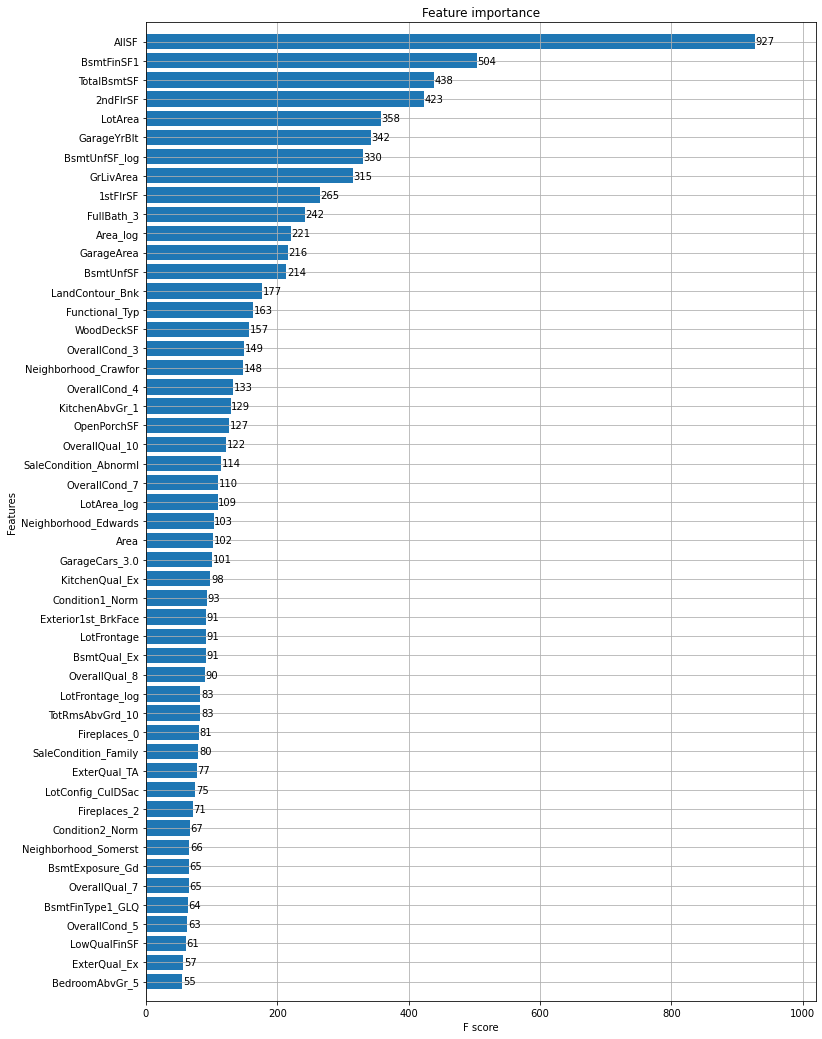

In [28]:
import matplotlib.pyplot as plt
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()